# Industrial Anomaly Detection and Localization on the MVTec Dataset
Davide Vettore - _Artificial Intelligence for Science and Technology_

The **MVTec Anomaly Detection** dataset is a comprehensive benchmark designed for evaluating anomaly detection methods, particularly in **industrial inspection** scenarios. This dataset includes over 5000 highresolution images divided into 15 categories, which include five **textures** and ten **objects**.

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
#import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

import torch.nn as nn
#import torch.nn.functional as F
from sklearn.metrics import jaccard_score
from torchsummary import summary
#from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


import kagglehub

# Download latest version
path = kagglehub.dataset_download("ipythonx/mvtec-ad")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mvtec-ad


### Data Loading

The [mvtec-ad](https://www.kaggle.com/datasets/ipythonx/mvtec-ad) dataset has the following folder structure:

<pre>
category (e.g., "leather")
└── ground_truth
    ├── defect_type_1
    │   └── file_name_mask.png
    ├── defect_type_2
    │   └── file_name_mask.png
    └── ...
└── test
    ├── defect_type_1
    │   └── file_name.png
    ├── defect_type_2
    │   └── file_name.png
    ├── ...
    └── good
        └── file_name.png
└── train
    └── good
        └── file_name.png
</pre>


In [30]:
# Define the MVTecDataset class

class MVTecDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        self.image_paths = []

        if mode == "train":
            train_good_dir = os.path.join(root_dir, "train", "good")
            for img in os.listdir(train_good_dir):
                img_path = os.path.join(train_good_dir, img)
                self.image_paths.append(img_path)

        elif mode == "test":
            test_dir = os.path.join(root_dir, "test")
            defect_types = os.listdir(test_dir)
            #print(defect_types)
            for defect in defect_types:
                defect_path = os.path.join(test_dir, defect)
                for img in os.listdir(defect_path):
                    img_path = os.path.join(defect_path, img)
                    self.image_paths.append(img_path)
           
        #print(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        #print(img_path)
        return image, img_path  

In [31]:
# Define transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet mean and std
])

# Load train and test datasets

class_path = "/kaggle/input/mvtec-ad/carpet" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")

train_dataset = MVTecDataset(root_dir=class_path, mode="train", transform=transform)
test_dataset = MVTecDataset(root_dir=class_path, mode="test", transform=transform)

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 280
Number of test samples: 117


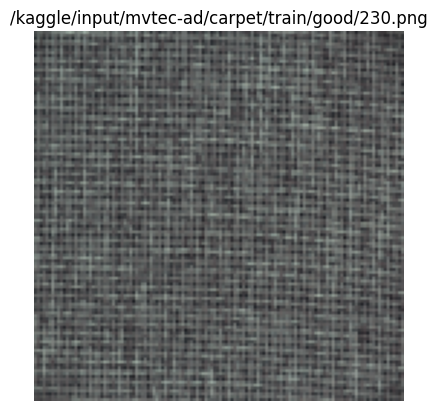

In [32]:
# Example of image from a training batch

images, paths = next(iter(train_loader))  # get a single batch
img = images[0]

# Denormalization 
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = img * std + mean

# Convert from [C, H, W] to [H, W, C]
img = img.permute(1, 2, 0).numpy()

#plt.figure(figsize=(1.28, 1.28), dpi=100)  # the image it's actually 128x128x3 but matplotlib automatically scales it
plt.title(paths[0])
plt.axis("off")
plt.imshow(img)
plt.show()       

# Deep Autoencoder

**Deep Autoencoders** are neural networks designed to learn efficient representations of input data through encoding and decoding phases. The encoder compresses the input into a lower-dimensional latent space, while the decoder reconstructs the input from this latent representation. For anomaly detection, the **reconstruction error**, calculated as the difference between the input and its reconstruction, is used as an indicator of abnormality. 

### Model Definition

In [33]:
# Autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Latent Space
        self.fc_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 128),  
            nn.ReLU()
        )
        self.fc_decoder = nn.Sequential(
            nn.Linear(128, 512 * 8 * 8),
            nn.Unflatten(1, (512, 8, 8)),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Block 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Block 3
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Block 2
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 1
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Normalize outputs to [0, 1]
        )
    
    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Latent Space
        z = self.fc_encoder(x)
        x = self.fc_decoder(z)
        
        # Decoder
        x = self.decoder(x)
        return x


#torch.manual_seed(5) 
autoencoder = Autoencoder().to(device)
summary(autoencoder, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,200
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,544
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       2,097,664
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
             ReLU-12            [-1, 512, 8, 8]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [34]:
# Loss Function: MSE

loss_fn = nn.MSELoss().to(device)

### Training

In [35]:
# Training parameters
learning_rate = 1e-3
num_epochs = 10

# Optimizer for the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Lists to store losses for plotting
reconstruction_losses = []

# Training Loop
for epoch in range(num_epochs):
    autoencoder.train()
    epoch_rec_loss = 0.0

    for images, _ in tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]"):
        
        images = images.to(device)

        # Get reconstruction with forward pass
        reconstructed = autoencoder(images)

        # Compute reconstruction loss
        loss = loss_fn(images, reconstructed)

        # Backpropagation
        optimizer_ae.zero_grad()
        loss.backward()

        # Update weights
        optimizer_ae.step()

        # Accumulate epoch losses
        epoch_rec_loss += loss.item()

    # Compute average reconstruction loss for the epoch
    avg_rec_loss = epoch_rec_loss / len(train_loader)
    reconstruction_losses.append(avg_rec_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Reconstruction Loss: {avg_rec_loss:.4f}")


torch.save(autoencoder.state_dict(), "autoencoder.pth")
print("Training complete")

Epoch [1/10]: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [1/10], Reconstruction Loss: 0.8278


Epoch [2/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [2/10], Reconstruction Loss: 0.5391


Epoch [3/10]: 100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


Epoch [3/10], Reconstruction Loss: 0.4301


Epoch [4/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [4/10], Reconstruction Loss: 0.3882


Epoch [5/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [5/10], Reconstruction Loss: 0.3609


Epoch [6/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [6/10], Reconstruction Loss: 0.3449


Epoch [7/10]: 100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


Epoch [7/10], Reconstruction Loss: 0.3352


Epoch [8/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [8/10], Reconstruction Loss: 0.3312


Epoch [9/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [9/10], Reconstruction Loss: 0.3286


Epoch [10/10]: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

Epoch [10/10], Reconstruction Loss: 0.3269
Training complete


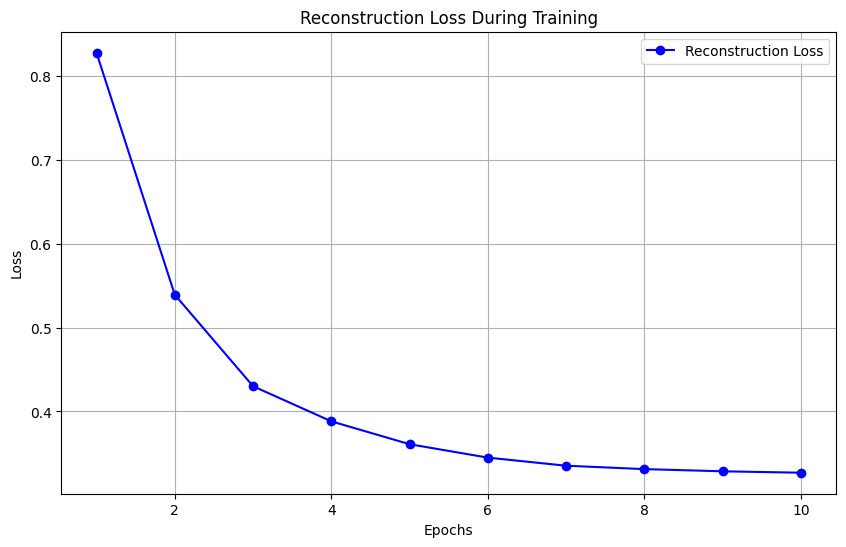

In [36]:
# Visualize Reconstruction Loss Evolution

def plot_losses(losses, title, label, color="b", marker="o"):
   
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, label=label, color=color, marker=marker)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(reconstruction_losses, "Reconstruction Loss During Training", "Reconstruction Loss", color="b")

### Evaluation

#### Anomaly detection
For anomaly detection, I compute anomaly scores, analyze detection AUROC as the primary metric, and assess additional metrics such as accuracy and precision.

In [37]:
# Calculate Anomaly Scores

def evaluate_anomaly_detection(test_loader, anomaly_score_fn):
    
    anomaly_scores = []
    true_labels = []
    image_paths = []
    
    for inputs, paths in tqdm(test_loader, desc="Calculating Anomaly Scores"):
        inputs = inputs.to(device)
        
        scores = anomaly_score_fn(inputs)
        anomaly_scores.extend(scores)
        image_paths.extend(paths)
        
        labels = [0 if "good" in path else 1 for path in paths] # For later evaluations
        true_labels.extend(labels)

    anomaly_scores = np.array(anomaly_scores)
    normalized_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    
    return anomaly_scores, normalized_scores, true_labels, image_paths

def DA_anomaly_score(inputs):

    autoencoder.eval()
    with torch.no_grad():
        
        reconstructed = autoencoder(inputs)
        rec_error = torch.mean((inputs - reconstructed) ** 2, dim=[1, 2, 3]) # MSE

    return rec_error.cpu().numpy()


anomaly_scores, normalized_scores, true_labels, image_paths = evaluate_anomaly_detection(test_loader, DA_anomaly_score)

Calculating Anomaly Scores: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


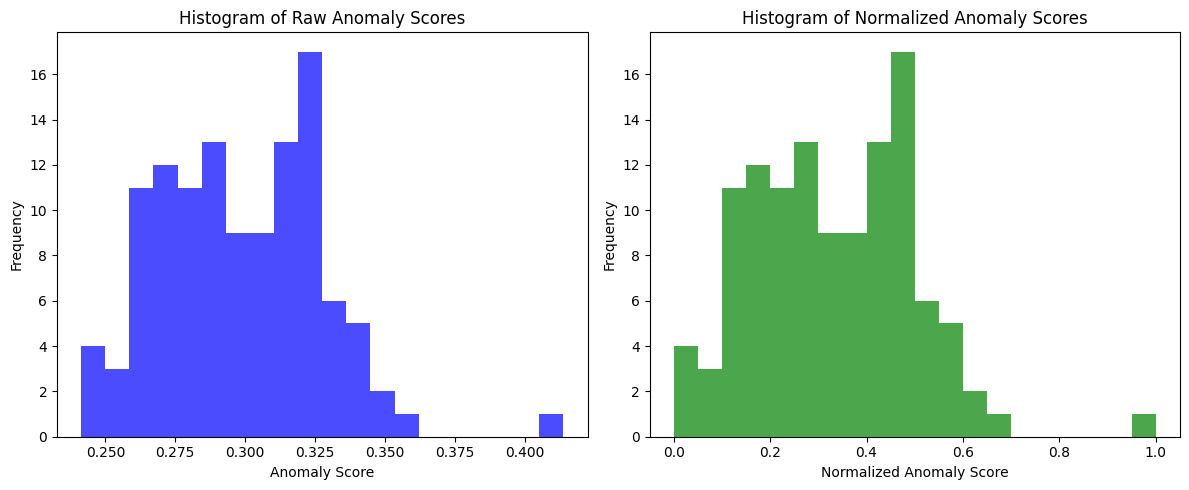

In [38]:
# Visualize Anomaly Scores Frequencies

def plot_anomaly_score_histograms(anomaly_scores, normalized_scores, bins=20):
    
    plt.figure(figsize=(12, 5))
    
    # Raw scores histogram
    plt.subplot(1, 2, 1)
    plt.hist(anomaly_scores, bins=bins, color='blue', alpha=0.7)
    plt.title("Histogram of Raw Anomaly Scores")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    
    # Normalized scores histogram
    plt.subplot(1, 2, 2)
    plt.hist(normalized_scores, bins=bins, color='green', alpha=0.7)
    plt.title("Histogram of Normalized Anomaly Scores")
    plt.xlabel("Normalized Anomaly Score")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()


plot_anomaly_score_histograms(anomaly_scores, normalized_scores, bins=20)

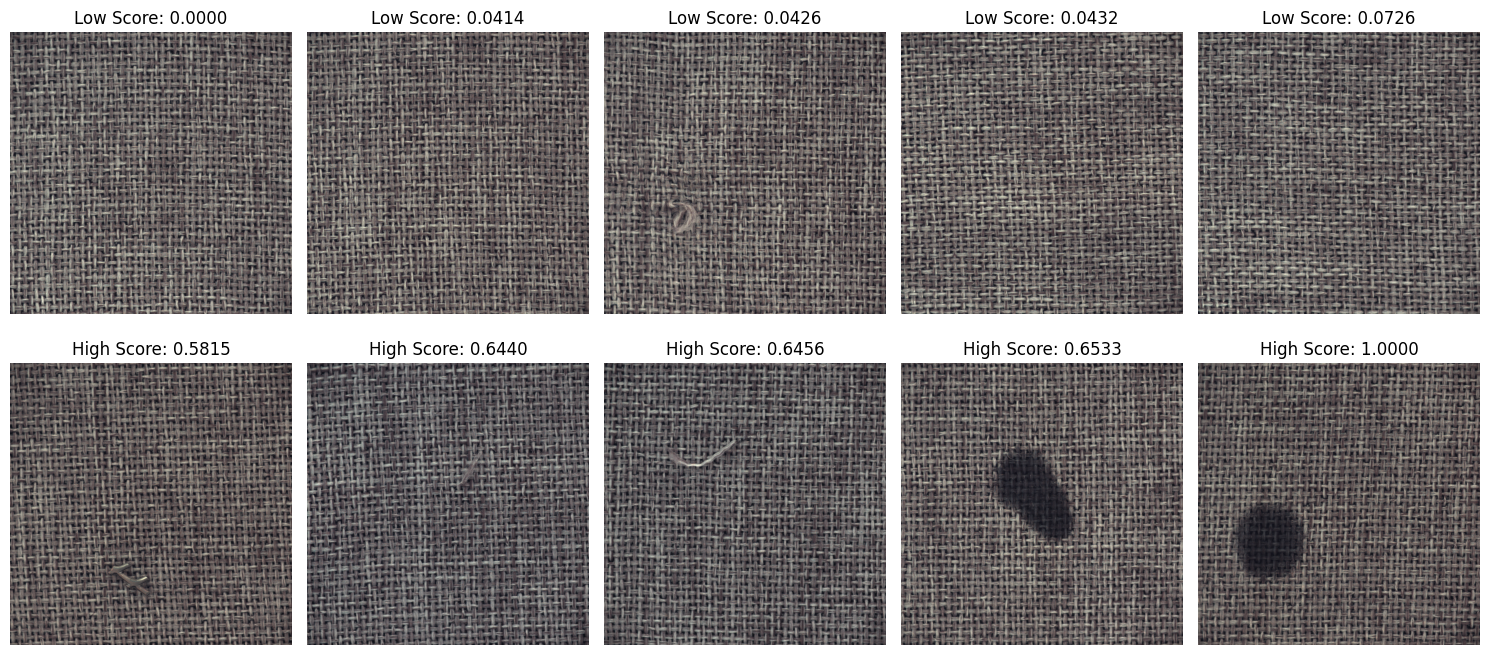

In [39]:
# Visualize Anomaly Scores Extremes

def visualize_anomaly_scores(image_paths, normalized_scores, num_images=5):
    
    # Sort indices based on scores
    sorted_indices = np.argsort(normalized_scores)
    lowest_indices = sorted_indices[:num_images]
    highest_indices = sorted_indices[-num_images:]
    
    plt.figure(figsize=(15, 7))
    
    # Plot images with lowest scores
    for i, idx in enumerate(lowest_indices):
        img = Image.open(image_paths[idx])
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Low Score: {normalized_scores[idx]:.4f}")
        plt.axis("off")
    
    # Plot images with highest scores
    for i, idx in enumerate(highest_indices):
        img = Image.open(image_paths[idx])
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(img)
        plt.title(f"High Score: {normalized_scores[idx]:.4f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


visualize_anomaly_scores(image_paths, normalized_scores, num_images=5)

In [47]:
# Evaluate Detection Performance

def evaluate_detection_performance(true_labels, normalized_scores, threshold=0.2):

    # Predict labels based on threshold
    #threshold = np.percentile(normalized_scores, 20)
    predicted_labels = [1 if score > threshold else 0 for score in normalized_scores]
    
    # Compute metrics
    metrics = {
        "AUROC": roc_auc_score(true_labels, normalized_scores),
        "Accuracy": accuracy_score(true_labels, predicted_labels),
        "Precision": precision_score(true_labels, predicted_labels),
        "Recall": recall_score(true_labels, predicted_labels),
        "F1-Score": f1_score(true_labels, predicted_labels)
    }
    
    print(f"Detection AUROC: {metrics['AUROC']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    
    return metrics, predicted_labels


metrics, predicted_labels = evaluate_detection_performance(true_labels, normalized_scores, threshold=0.2)

Detection AUROC: 0.9025
Accuracy: 0.8632
Precision: 0.9195
Recall: 0.8989
F1-Score: 0.9091


In [48]:
# Visualize all labels

def visualize_labels(image_paths, normalized_scores, predicted_labels, columns=5):
   
    rows = int(np.ceil(len(image_paths) / columns)) 
    
    plt.figure(figsize=(columns * 3, rows * 3)) 
    
    for i, (path, score, label) in enumerate(zip(image_paths, normalized_scores, predicted_labels)):
        img = Image.open(path)  
        label_text = "Anomalous" if label == 1 else "Normal"  

        # Plot the image
        plt.subplot(rows, columns, i + 1)  
        plt.imshow(img)
        plt.title(f"Score: {score:.4f}\nLabel: {label_text}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    
#visualize_labels(image_paths, normalized_scores, predicted_labels, columns=5)

#### Anomaly Localization
For anomaly localization, I compare the spatial identification of anomalies using localization AUROC, visualize examples, and calculate mean intersection over union (mIoU) as an overlap metric with groundtruth masks.

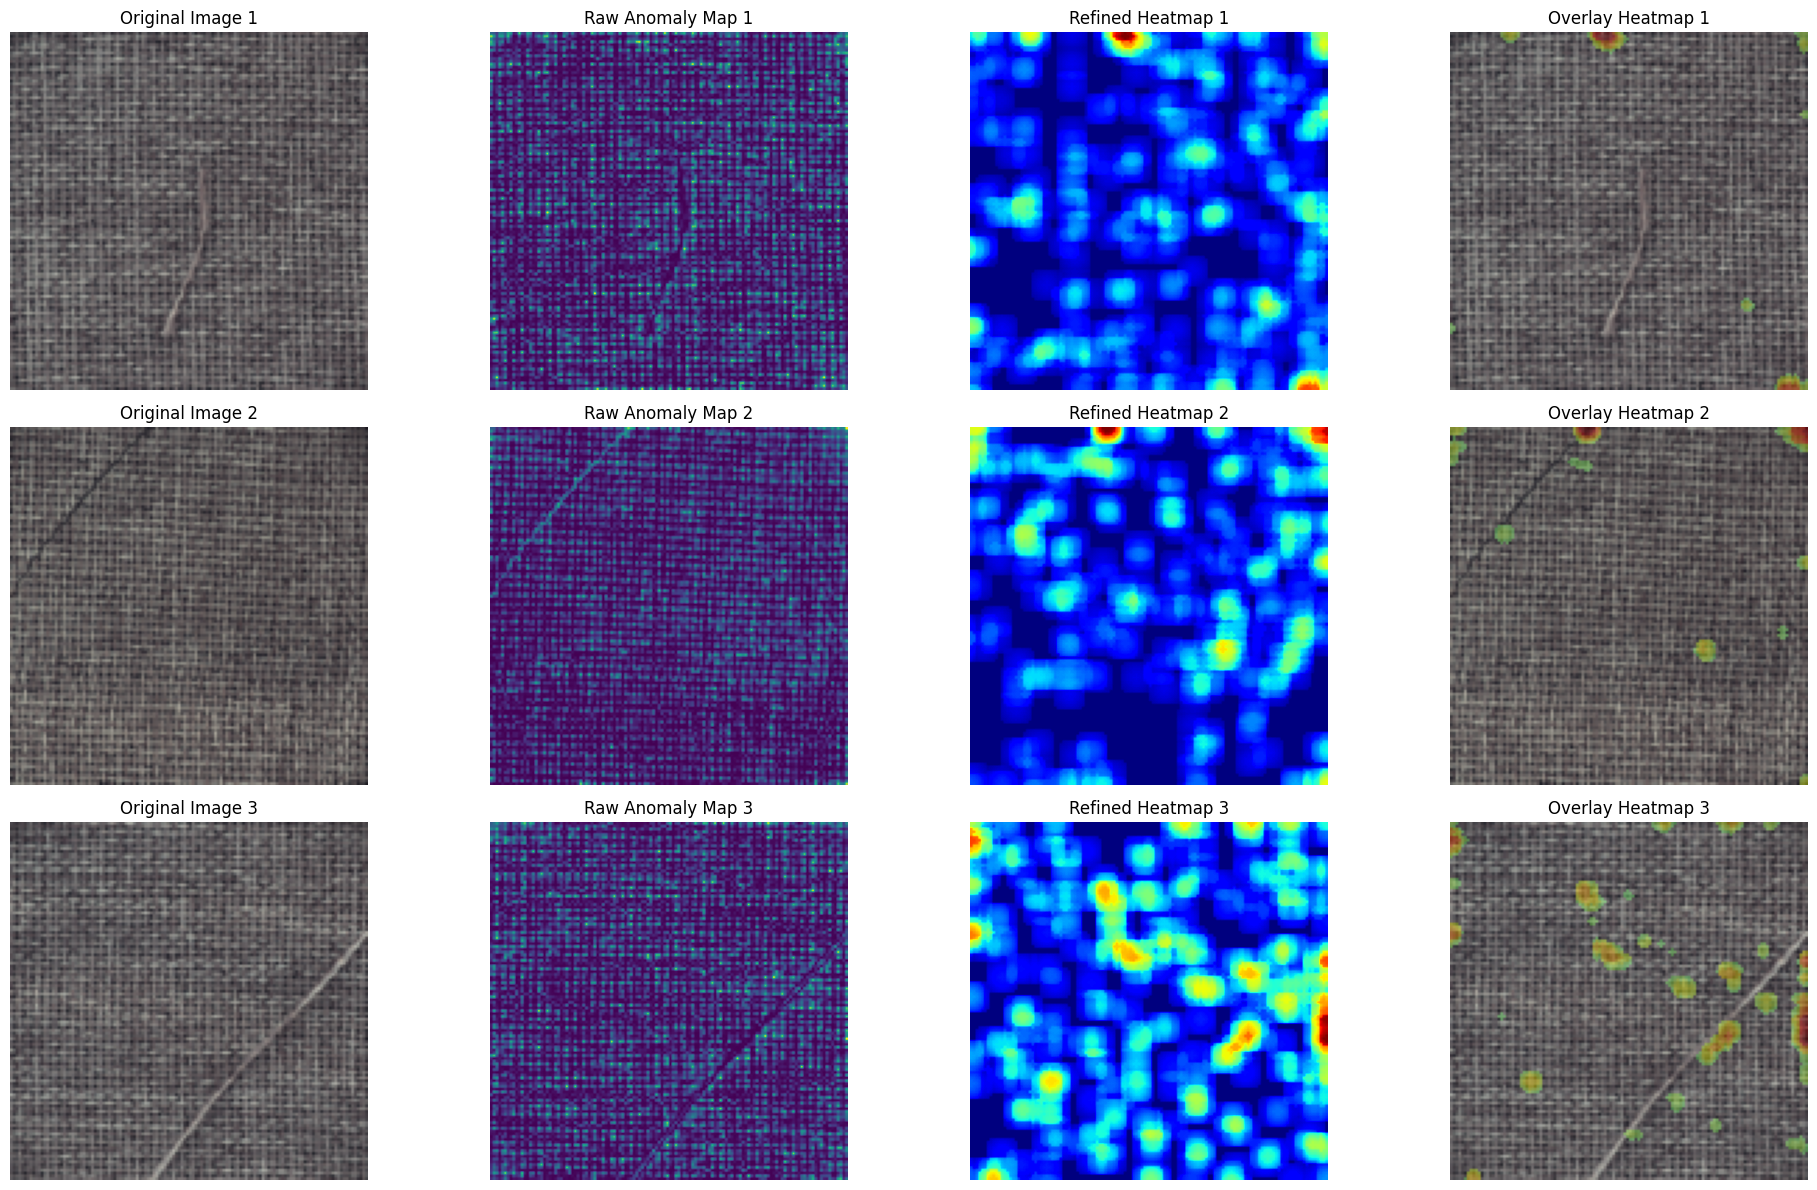

In [49]:
# Visualize Raw and Processed Heatmaps

def visualize_anomaly_heatmaps(test_loader, anomaly_localization_fn, num_images_to_display=5):

    total_images = 0
    plt.figure(figsize=(20, num_images_to_display * 4))

    for inputs, paths in test_loader:
        inputs = inputs.to(device)

        for i in range(len(inputs)):
            if total_images >= num_images_to_display:
                break
            
            input_image = inputs[i]
            if anomaly_localization_fn == "da":
                raw_heatmap, processed_heatmap = da_anomaly_localization(autoencoder, input_image)
            elif anomaly_localization_fn == "kd":
                raw_heatmap, processed_heatmap = kd_anomaly_localization(input_image, criterion)
            else:
                print("Unknown Function")

            # Convert the original image to HWC format for display
            original_image = input_image.cpu() * std.cpu() + mean.cpu()
            original_image = original_image.permute(1, 2, 0).detach().numpy() #

            # Overlay heatmap
            mask = processed_heatmap > 0.50
            heatmap_colored = np.zeros((*processed_heatmap.shape, 3)) 
            if mask.any():  
                normalized_heatmap = processed_heatmap[mask] / processed_heatmap[mask].max()
                heatmap_colored[mask] = plt.cm.jet(normalized_heatmap)[..., :3]
            overlay = original_image.copy() 
            overlay[mask] = 0.6 * original_image[mask] + 0.4 * heatmap_colored[mask]  
            overlay = np.clip(overlay, 0, 1)  

            # Plot the original image
            plt.subplot(num_images_to_display, 4, total_images * 4 + 1)
            plt.imshow(original_image)
            plt.title(f"Original Image {total_images + 1}")
            plt.axis("off")

            # Plot the raw anomaly map
            plt.subplot(num_images_to_display, 4, total_images * 4 + 2)
            plt.imshow(raw_heatmap, cmap="viridis")
            plt.title(f"Raw Anomaly Map {total_images + 1}")
            plt.axis("off")

            # Plot the refined heatmap
            plt.subplot(num_images_to_display, 4, total_images * 4 + 3)
            plt.imshow(processed_heatmap, cmap="jet")
            plt.title(f"Refined Heatmap {total_images + 1}")
            plt.axis("off")

            # Plot the overlayed heatmap
            plt.subplot(num_images_to_display, 4, total_images * 4 + 4)
            plt.imshow(overlay)
            plt.title(f"Overlay Heatmap {total_images + 1}")
            plt.axis("off")

            total_images += 1

        if total_images >= num_images_to_display:
            break

    plt.tight_layout()
    plt.show()


def da_anomaly_localization(autoencoder, image):
   
    autoencoder.eval()

    with torch.no_grad():
        
        image = image.unsqueeze(0).to(device) # Single image to aderhe with visualization def
        reconstructed = autoencoder(image)

        # Pixel-wise reconstruction error
        rec_error = ((image - reconstructed) ** 2).mean(dim=1).cpu().numpy()

        # Normalize the heatmap to [0, 1]
        raw_heatmap = (rec_error[0] - rec_error.min()) / (rec_error.max() - rec_error.min())

        # Thresholding and Morphological operations
        threshold = np.percentile(raw_heatmap, 98)
        processed_heatmap = np.zeros_like(raw_heatmap)
        processed_heatmap[raw_heatmap > threshold] = raw_heatmap[raw_heatmap > threshold]
        processed_heatmap = cv2.GaussianBlur(processed_heatmap, (11, 11), sigmaX=5, sigmaY=5)   
        B = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize = (3, 3))  
        processed_heatmap = cv2.morphologyEx(processed_heatmap, cv2.MORPH_OPEN, B)
        processed_heatmap = (processed_heatmap - processed_heatmap.min()) / (processed_heatmap.max() - processed_heatmap.min())
        
    return raw_heatmap, processed_heatmap


visualize_anomaly_heatmaps(test_loader,"da", num_images_to_display=3)

In [50]:
# Evaluate Localization Performance

def compute_localization_metrics(test_loader, anomaly_localization_fn, threshold=0.6):
    
    pixel_true_labels = []       # Each of these becomes n*128*128
    pixel_predicted_scores = [] 
    pixel_predicted_masks = []  

    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        for i in range(inputs.size(0)):
            input_image = inputs[i]
            if anomaly_localization_fn == "da":
                raw_heatmap, processed_heatmap = da_anomaly_localization(autoencoder, input_image)
            elif anomaly_localization_fn == "kd":
                raw_heatmap, processed_heatmap = kd_anomaly_localization(input_image, criterion)
            else:
                print("Unknown Function")

            # Determine the corresponding ground truth mask path
            ground_truth_path = paths[i].replace("test", "ground_truth").replace(".png", "_mask.png")

            # If ground truth mask exists, load and preprocess it
            if os.path.exists(ground_truth_path):
                ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
                ground_truth_mask = cv2.resize(ground_truth_mask, processed_heatmap.shape[::-1], interpolation=cv2.INTER_NEAREST)
                ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)
            else:
                # For "good" samples, create an all-zero mask
                ground_truth_mask = np.zeros_like(processed_heatmap, dtype=np.uint8)

            # Generate predicted mask based on the threshold
            threshold = np.percentile(raw_heatmap, 98)        # Alternative: does not use the input threshold
            predicted_mask = (processed_heatmap > threshold).astype(np.uint8) 
            #predicted_mask = cv2.GaussianBlur(predicted_mask, (5, 5), sigmaX=5, sigmaY=5) # Alternative: extra morph for binary mask
            #B = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize = (3, 3)) 
            #predicted_mask = cv2.morphologyEx(predicted_mask, cv2.MORPH_OPEN, B) 

            # Append ground truth and predicted data for metric computation
            pixel_true_labels.extend(ground_truth_mask.flatten())
            pixel_predicted_scores.extend(processed_heatmap.flatten())
            pixel_predicted_masks.extend(predicted_mask.flatten())

    print(f"Localization AUROC: {roc_auc_score(pixel_true_labels, pixel_predicted_scores):.4f}")
    print(f"Pixel-Level Accuracy: {accuracy_score(pixel_true_labels, pixel_predicted_masks):.4f}")

    return pixel_true_labels, pixel_predicted_scores, pixel_predicted_masks


pixel_true_labels, pixel_predicted_scores, pixel_predicted_masks = compute_localization_metrics(test_loader, "da", threshold=0.6)

Localization AUROC: 0.7276
Pixel-Level Accuracy: 0.9784


In [51]:
# Define Overlap Metrics and Visualization

def overlap_metrics(predicted_mask, ground_truth_mask):
    
    # Flatten masks for computation
    predicted_flat = predicted_mask.flatten()
    ground_truth_flat = ground_truth_mask.flatten()

    # Compute IoU
    iou = jaccard_score(ground_truth_flat, predicted_flat)

    # Compute Dice coefficient
    intersection = np.sum(predicted_flat * ground_truth_flat)
    dice = (2.0 * intersection) / (np.sum(predicted_flat) + np.sum(ground_truth_flat) + 1e-6)

    # Compute pixel-wise accuracy
    total_pixels = len(predicted_flat)
    correct_predictions = np.sum(predicted_flat == ground_truth_flat)
    accuracy = correct_predictions / total_pixels

    return iou, dice, accuracy

# This also computes average overlap metrics
def visualize_binary_masks(pixel_true_labels, pixel_predicted_masks, image_height=128, image_width=128):
    
    num_images = len(pixel_true_labels) // (image_height * image_width)
    gt_masks = np.array(pixel_true_labels).reshape(num_images, image_height, image_width)
    predicted_masks = np.array(pixel_predicted_masks).reshape(num_images, image_height, image_width)

    iou_list = []
    dice_list = []
    accuracy_list = []

    #plt.figure(figsize=(15, num_images * 5))    # This allows to visualize all predicted masks

    for i in range(num_images):
        if np.any(gt_masks[i]):  # Only compute metrics if there is a defect
            
            iou, dice, accuracy = overlap_metrics(predicted_masks[i], gt_masks[i])
            
            iou_list.append(iou)
            dice_list.append(dice)
            accuracy_list.append(accuracy)
            
            title = f"Pred Mask {i + 1}\nIoU: {iou:.3f}, Dice: {dice:.3f}, Acc: {accuracy:.3f}"
        else:
            # No defect, no metrics computed
            title = f"Pred Mask {i + 1}\nNo Defects in GT"

        # Ground truth mask
        #plt.subplot(num_images, 2, i * 2 + 1)
        #plt.imshow(gt_masks[i], cmap="gray")
        #plt.title(f"GT Mask {i + 1}")
        #plt.axis("off")

        # Predicted mask 
        #plt.subplot(num_images, 2, i * 2 + 2)
        #plt.imshow(predicted_masks[i], cmap="gray")
        #plt.title(title)
        #plt.axis("off")

    #plt.tight_layout()
    #plt.show()

    # Compute and return average metrics
    average_iou = np.mean(iou_list)
    average_dice = np.mean(dice_list)
    average_accuracy = np.mean(accuracy_list)

    return average_iou, average_dice, average_accuracy
    

da_iou, da_dice, da_accuracy = visualize_binary_masks(pixel_true_labels, pixel_predicted_masks)

print(f"Average IoU: {da_iou:.3f}")
print(f"Average Dice Coefficient: {da_dice:.3f}")
print(f"Average Accuracy: {da_accuracy:.3f}")

Average IoU: 0.149
Average Dice Coefficient: 0.225
Average Accuracy: 0.975


# Multiresolution Knowledge Distillation

**Multiresolution Knowledge Distillatio**n is an advanced anomaly detection framework that leverages the principles of knowledge distillation. This approach utilizes a **two-network setup**: a robust, pretrained ‘expert’ network and a simpler ‘cloner’ network. The expert network extracts rich, multiscale features from the input data, which are then transferred to the cloner by aligning the intermediate outputs of both networks across multiple **critical layers**. This process ensures that the cloner network learns to replicate the expert’s feature representations at different spatial resolutions. During inference, discrepancies between the outputs of the expert and cloner networks at these key points signal anomalies, as the cloner struggles to mimic the expert’s feature maps when exposed to anomalous inputs.

### Models Definition

#### Expert Network
The source network is a [VGG-16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html), the same utilized in the litterature. The final layers of each convolutional block, i.e., max-pooling layers, are chosen to be the critical points. We use only features attribute of the VGG-16 model, which contains only the convolutional and pooling layers. This means the fully connected (FC) layers at the end of the VGG-16 architecture are not included.

In [86]:
# Let's look at the source model first 

vgg = models.vgg16(weights=True).features # exlude FC part

summary(vgg.to(device), input_size=(3, 128, 128)) # the critical points will be at layers: 10, 17, 24, 30

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [87]:
# Load the pre-trained VGG-16 as the expert network

class ExpertVGG16(nn.Module):
    def __init__(self):
        super(ExpertVGG16, self).__init__()
        self.vgg = models.vgg16(weights=True).features

    def forward(self, x):
        critical_points = [10, 17, 24, 30]  # Critical points
        outputs = []
        
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in critical_points:
                outputs.append(x)
        return outputs  # Activation maps at critical points

expert = ExpertVGG16().to(device)
expert.eval()  # Freeze the expert network

ExpertVGG16(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Critical Point 1 - Total Feature Maps: 256


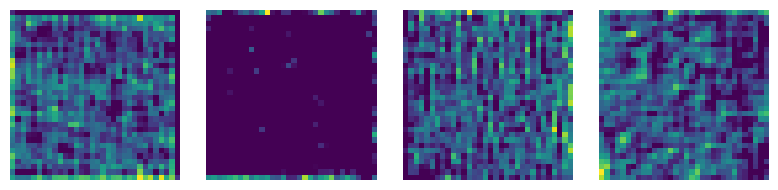

Critical Point 2 - Total Feature Maps: 512


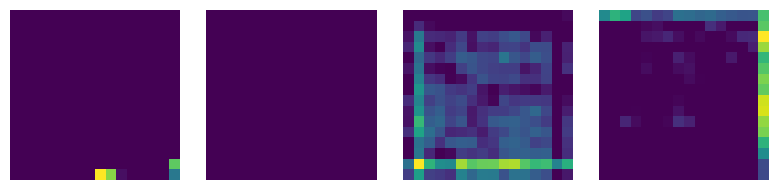

Critical Point 3 - Total Feature Maps: 512


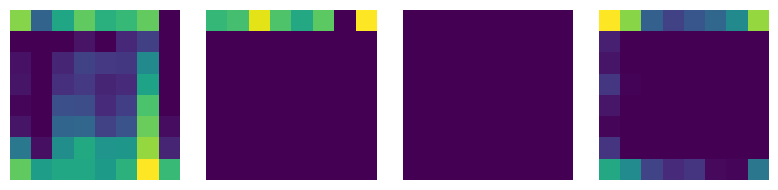

Critical Point 4 - Total Feature Maps: 512


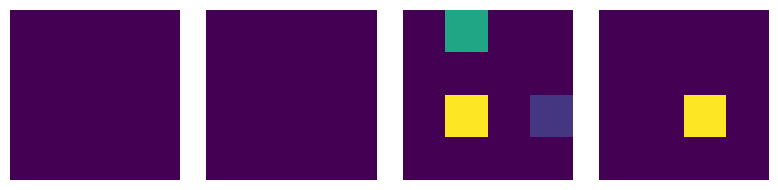

In [88]:
# Visualize some feature maps at each critical point using a test image.
# This allows us to see what kind of features (edges, textures, semantic structures) each layer extracts.

image_path = "/kaggle/input/mvtec-ad/carpet/train/good/001.png"  
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)  # add batch dimension
input_image = input_image.to(device)

# Get feature maps at critical points
critical_outputs = expert(input_image)

# Visualize feature maps
for idx, feature_map in enumerate(critical_outputs):
    print(f"Critical Point {idx + 1} - Total Feature Maps: {feature_map.shape[1]}")
    
    plt.figure(figsize=(8, 2)) 

    for i in range(4):
        plt.subplot(1, 4, i + 1)  
        plt.imshow(feature_map[0, i].detach().cpu().numpy(), cmap="viridis")  
        plt.axis("off")
    
    plt.tight_layout()  
    plt.show()

#### Cloner Network

The cloner network is a compact version of the teacher network, it is trained to mimic the intermediate features of the expert network at specific critical points. These features help distinguish normal from anomalous inputs based on the discrepancy between the two networks.

In [89]:
# Define a compact cloner network 

class ClonerNet(nn.Module):
    def __init__(self):
        super(ClonerNet, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def forward(self, x):
        critical_points = [10, 15, 20, 24]       #[5, 10, 15, 20]
        outputs = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in critical_points:
                outputs.append(x)
        return outputs


cloner = ClonerNet().to(device)
summary(cloner, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
         MaxPool2d-5           [-1, 16, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          18,560
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [90]:
# We need to align output sizes between the cloner and expert for the knowledge distillation process

for inputs, _ in train_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        expert_outputs = expert(inputs)
    cloner_outputs = cloner(inputs)

    print("Expert outputs:", [e.shape for e in expert_outputs])
    print("Cloner outputs:", [c.shape for c in cloner_outputs])
    break

Expert outputs: [torch.Size([32, 256, 32, 32]), torch.Size([32, 512, 16, 16]), torch.Size([32, 512, 8, 8]), torch.Size([32, 512, 4, 4])]
Cloner outputs: [torch.Size([32, 256, 32, 32]), torch.Size([32, 512, 16, 16]), torch.Size([32, 512, 8, 8]), torch.Size([32, 512, 4, 4])]


In [91]:
# Loss Function: Multi-KD 

class MultiKDLoss(nn.Module):
    def __init__(self, lambda_dir=0.1):
        
        super(MultiKDLoss, self).__init__()
        self.lambda_dir = lambda_dir

    def forward(self, cloner_outputs, expert_outputs):
        
        # Value loss: Mean squared error (MSE)
        l_val = sum(torch.mean((c - e) ** 2) for c, e in zip(cloner_outputs, expert_outputs))
        
        # Directional loss: 1 - cosine similarity
        l_dir = sum(1 - nn.functional.cosine_similarity(c.flatten(1), e.flatten(1)).mean()
                    for c, e in zip(cloner_outputs, expert_outputs))
        
        return l_val + self.lambda_dir * l_dir


lambda_dir = 0.1
criterion = MultiKDLoss(lambda_dir=lambda_dir)

### Training

In [92]:
# Training Parameters
learning_rate = 1e-3
epochs = 75

optimizer = optim.Adam(cloner.parameters(), lr=learning_rate)

epoch_losses = []
os.makedirs("feature_maps", exist_ok=True) # To save the evolution of a sample map during training

# Training Loop
for epoch in range(epochs):
    cloner.train()
    running_loss = 0.0

    for batch_idx, (inputs, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        inputs = inputs.to(device)

        # Forward pass through the (frozen) expert network
        with torch.no_grad(): 
            expert_outputs = expert(inputs)

        # Forward pass through the cloner network
        cloner_outputs = cloner(inputs)

        # Compute loss
        loss = criterion(cloner_outputs, expert_outputs)

        # Save feature maps for the first sample in the batch for visualization
        if batch_idx == 0:  
            expert_feature_map = expert_outputs[0][0, 3].cpu().detach().numpy()  # The third map looked cool before
            cloner_feature_map = cloner_outputs[0][0, 3].cpu().detach().numpy()

            np.save(f"feature_maps/epoch_{epoch+1}_expert.npy", expert_feature_map)
            np.save(f"feature_maps/epoch_{epoch+1}_cloner.npy", cloner_feature_map)
   
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)  
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

torch.save(cloner.state_dict(), "cloner_model.pth")
print("Training complete.")

Epoch 1/75: 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Epoch [1/75], Loss: 35.1311


Epoch 2/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [2/75], Loss: 23.3021


Epoch 3/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [3/75], Loss: 22.5428


Epoch 4/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [4/75], Loss: 21.2665


Epoch 5/75: 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


Epoch [5/75], Loss: 17.7523


Epoch 6/75: 100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


Epoch [6/75], Loss: 16.4043


Epoch 7/75: 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]


Epoch [7/75], Loss: 14.9429


Epoch 8/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [8/75], Loss: 11.1929


Epoch 9/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [9/75], Loss: 7.2492


Epoch 10/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [10/75], Loss: 5.5579


Epoch 11/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [11/75], Loss: 4.6780


Epoch 12/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [12/75], Loss: 4.3596


Epoch 13/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [13/75], Loss: 4.2084


Epoch 14/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [14/75], Loss: 4.1161


Epoch 15/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [15/75], Loss: 4.0393


Epoch 16/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [16/75], Loss: 3.9523


Epoch 17/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [17/75], Loss: 3.8390


Epoch 18/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [18/75], Loss: 3.6836


Epoch 19/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [19/75], Loss: 3.4875


Epoch 20/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [20/75], Loss: 3.2616


Epoch 21/75: 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]


Epoch [21/75], Loss: 3.0854


Epoch 22/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [22/75], Loss: 2.9769


Epoch 23/75: 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Epoch [23/75], Loss: 2.8850


Epoch 24/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [24/75], Loss: 2.8310


Epoch 25/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [25/75], Loss: 2.7861


Epoch 26/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [26/75], Loss: 2.7600


Epoch 27/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [27/75], Loss: 2.7320


Epoch 28/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [28/75], Loss: 2.7182


Epoch 29/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [29/75], Loss: 2.7102


Epoch 30/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [30/75], Loss: 2.6980


Epoch 31/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [31/75], Loss: 2.6803


Epoch 32/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [32/75], Loss: 2.6725


Epoch 33/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [33/75], Loss: 2.6611


Epoch 34/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [34/75], Loss: 2.6536


Epoch 35/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [35/75], Loss: 2.6472


Epoch 36/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [36/75], Loss: 2.6385


Epoch 37/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [37/75], Loss: 2.6358


Epoch 38/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [38/75], Loss: 2.6258


Epoch 39/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [39/75], Loss: 2.6149


Epoch 40/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [40/75], Loss: 2.6037


Epoch 41/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [41/75], Loss: 2.6017


Epoch 42/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [42/75], Loss: 2.5950


Epoch 43/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [43/75], Loss: 2.5906


Epoch 44/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [44/75], Loss: 2.5723


Epoch 45/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [45/75], Loss: 2.5601


Epoch 46/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [46/75], Loss: 2.5472


Epoch 47/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [47/75], Loss: 2.5406


Epoch 48/75: 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Epoch [48/75], Loss: 2.5366


Epoch 49/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [49/75], Loss: 2.5335


Epoch 50/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [50/75], Loss: 2.5149


Epoch 51/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [51/75], Loss: 2.4981


Epoch 52/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [52/75], Loss: 2.5064


Epoch 53/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [53/75], Loss: 2.5185


Epoch 54/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [54/75], Loss: 2.5150


Epoch 55/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [55/75], Loss: 2.4865


Epoch 56/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [56/75], Loss: 2.4639


Epoch 57/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [57/75], Loss: 2.4547


Epoch 58/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [58/75], Loss: 2.4456


Epoch 59/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [59/75], Loss: 2.4420


Epoch 60/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [60/75], Loss: 2.4366


Epoch 61/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [61/75], Loss: 2.4311


Epoch 62/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [62/75], Loss: 2.4262


Epoch 63/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [63/75], Loss: 2.4226


Epoch 64/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [64/75], Loss: 2.4176


Epoch 65/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [65/75], Loss: 2.4104


Epoch 66/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [66/75], Loss: 2.4042


Epoch 67/75: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Epoch [67/75], Loss: 2.3993


Epoch 68/75: 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


Epoch [68/75], Loss: 2.3909


Epoch 69/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [69/75], Loss: 2.3829


Epoch 70/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [70/75], Loss: 2.3740


Epoch 71/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [71/75], Loss: 2.3721


Epoch 72/75: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Epoch [72/75], Loss: 2.3717


Epoch 73/75: 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Epoch [73/75], Loss: 2.3816


Epoch 74/75: 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


Epoch [74/75], Loss: 2.3638


Epoch 75/75: 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

Epoch [75/75], Loss: 2.3520
Training complete.


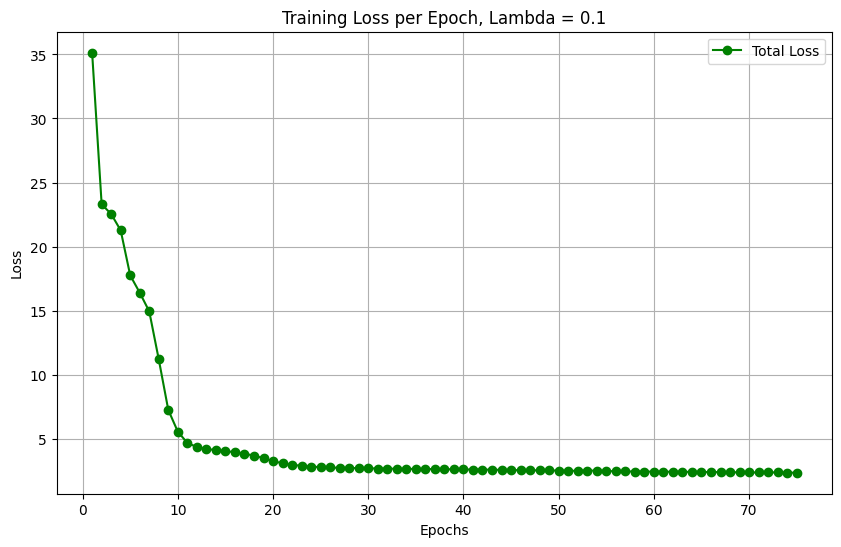

In [93]:
plot_losses(epoch_losses, f"Training Loss per Epoch, Lambda = {lambda_dir}", "Total Loss", color="g")

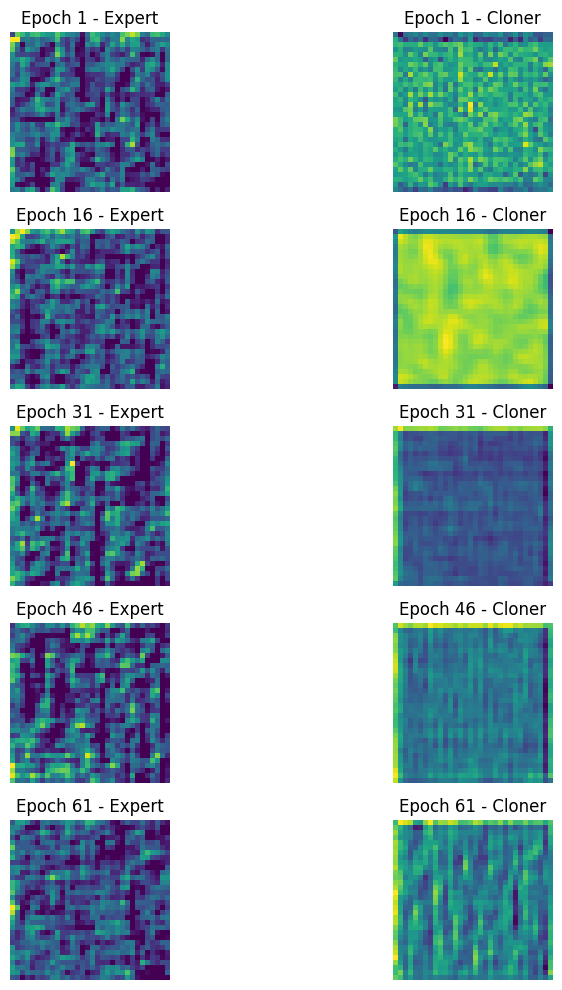

In [108]:
# Plot the evolution of feature maps

interval = 15
rows = epochs // interval

plt.figure(figsize=(10, rows * 2))  

for i, epoch in enumerate(range(1, epochs + 1, interval)):
    
    expert_map = np.load(f"feature_maps/epoch_{epoch}_expert.npy")
    cloner_map = np.load(f"feature_maps/epoch_{epoch}_cloner.npy")

    plt.subplot(rows, 2, i * 2 + 1) 
    plt.imshow(expert_map, cmap="viridis")
    plt.title(f"Epoch {epoch} - Expert")
    plt.axis("off")

    plt.subplot(rows, 2, i * 2 + 2)  
    plt.imshow(cloner_map, cmap="viridis")
    plt.title(f"Epoch {epoch} - Cloner")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Evaluation

#### Anomaly Detection
We calculate anomaly scores for input images by measuring the discrepancy between the outputs of the expert and cloner networks at their respective critical points.

In [95]:
# Calculate Anomaly Scores

def KD_anomaly_score(inputs):
    
    with torch.no_grad():
        
        expert_outputs = expert(inputs)
        cloner_outputs = cloner(inputs)

        # Compute discrepancy scores for each critical point
        discrepancy_scores = [
            torch.mean((c - e) ** 2, dim=[1, 2, 3]).cpu().numpy()
            for c, e in zip(cloner_outputs, expert_outputs)
        ]

        # Aggregate discrepancy scores for all critical points
        anomaly_scores = np.sum(discrepancy_scores, axis=0) 
        
    return anomaly_scores


anomaly_scores, normalized_scores, true_labels, image_paths = evaluate_anomaly_detection(test_loader, KD_anomaly_score)

Calculating Anomaly Scores: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


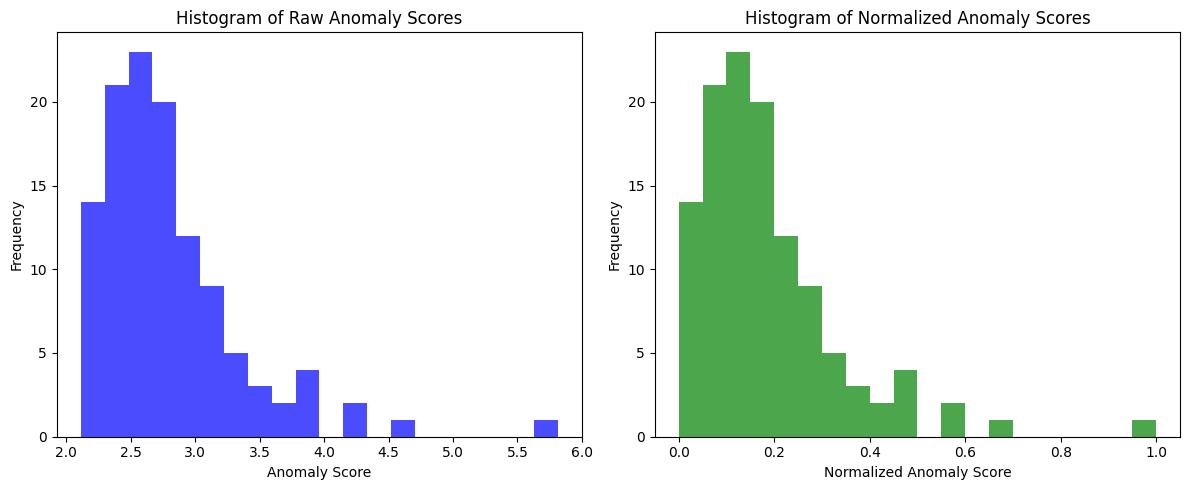

In [96]:
plot_anomaly_score_histograms(anomaly_scores, normalized_scores, bins=20)

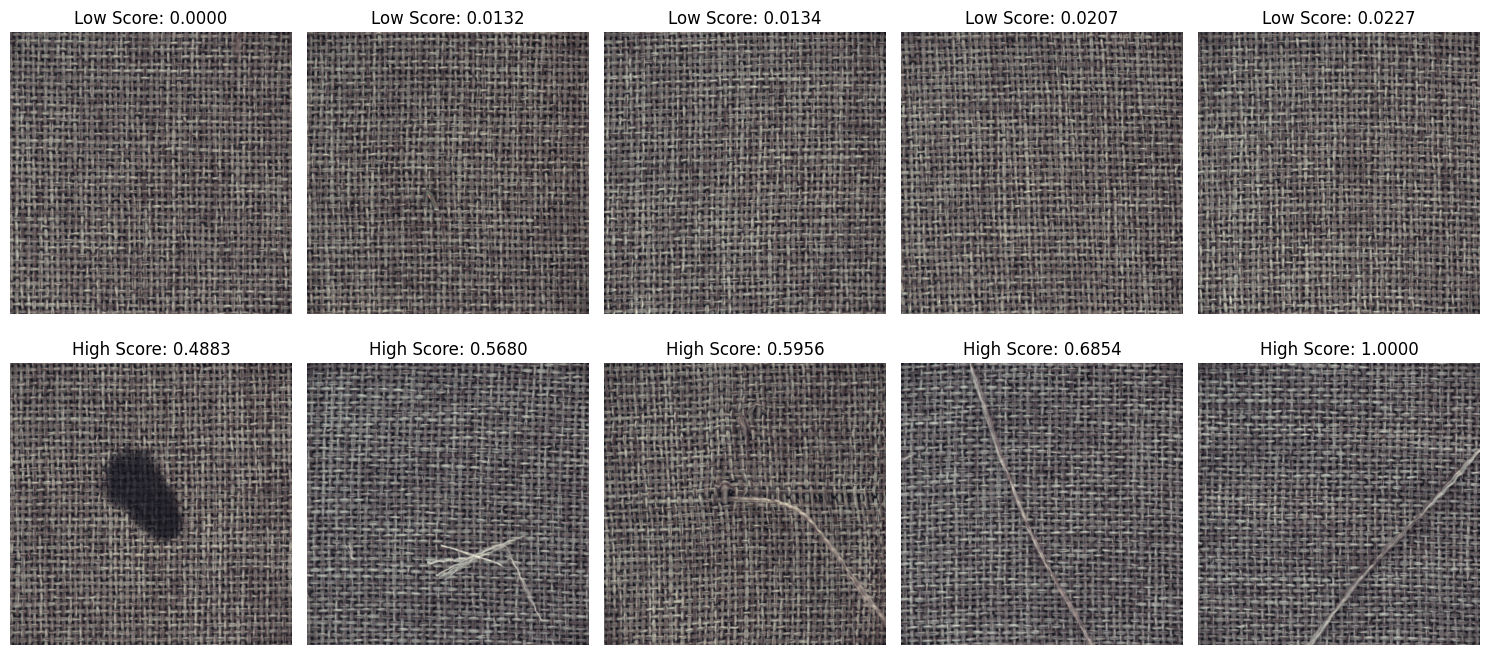

In [97]:
visualize_anomaly_scores(image_paths, normalized_scores, num_images=5)

In [98]:
metrics, predicted_labels = evaluate_detection_performance(true_labels, normalized_scores, threshold=0.1)

Detection AUROC: 0.7669
Accuracy: 0.7350
Precision: 0.8537
Recall: 0.7865
F1-Score: 0.8187


#### Anomaly Localization

It has been shown that derivative of the loss function with respect to the input has meaningful information about the significance of each pixel for the loss value. 

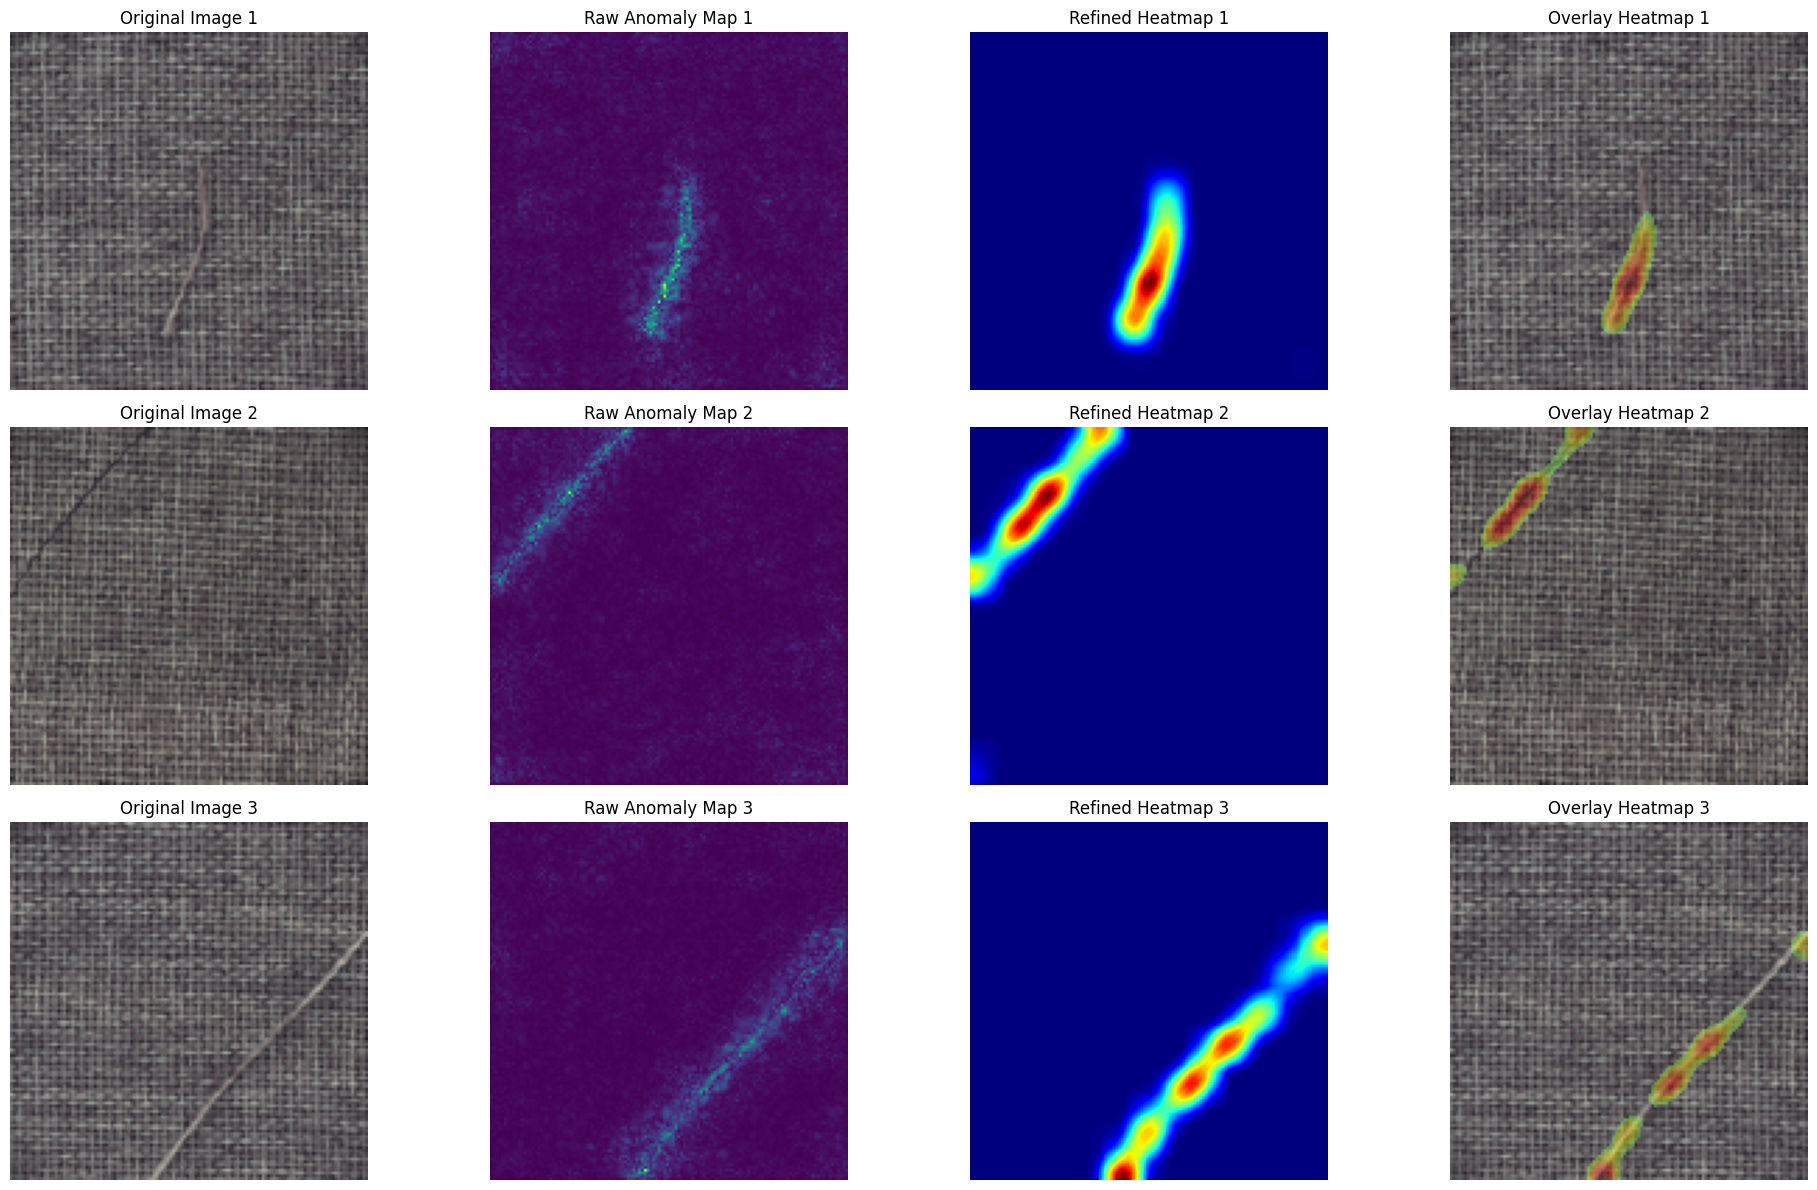

In [99]:
# Visualize Raw and Processed Heatmaps

def kd_anomaly_localization(input_image, criterion):

    input_image = input_image.to(device).requires_grad_(True)

    expert_outputs = expert(input_image.unsqueeze(0)) #Aadd batch dimension 
    cloner_outputs = cloner(input_image.unsqueeze(0))

    loss = criterion(cloner_outputs, expert_outputs) # I recall MultiKDLoss because the paper uses l_total
    loss.backward()  # Gradient of the loss with respect to the input image (raw attribution map stored in input_image.grad[0])
    gradients = input_image.grad.cpu().numpy() # Gradient with respect to the input
    
    raw_attribution_map = np.abs(gradients).sum(axis=0)  # Sum over the color channels  
    raw_attribution_map = (raw_attribution_map - raw_attribution_map.min()) / (raw_attribution_map.max() - raw_attribution_map.min())  
    
    # Morph op
    threshold = np.percentile(raw_attribution_map, 98)
    #print(threshold)
    processed_heatmap = np.zeros_like(raw_attribution_map)
    processed_heatmap[raw_attribution_map > threshold] = raw_attribution_map[raw_attribution_map > threshold]
    heatmap = cv2.GaussianBlur(processed_heatmap, (15, 15), sigmaX=5.0)   # In the paper: 5x5 and sigma = 4
    B = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # In the paper: 3x3 structural element
    heatmap = cv2.morphologyEx(heatmap, cv2.MORPH_OPEN, B) # Apply morphological opening 
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize the heatmap 

    return raw_attribution_map, heatmap
    
visualize_anomaly_heatmaps(test_loader,"kd", num_images_to_display=3)

In [100]:
pixel_true_labels, pixel_predicted_scores, pixel_predicted_masks = compute_localization_metrics(test_loader, "kd", threshold=0.5)

Localization AUROC: 0.9584
Pixel-Level Accuracy: 0.9693


In [101]:
kd_iou, kd_dice, kd_accuracy = visualize_binary_masks(pixel_true_labels, pixel_predicted_masks)

print(f"Average IoU: {kd_iou:.3f}")
print(f"Average Dice Coefficient: {kd_dice:.3f}")
print(f"Average Accuracy: {kd_accuracy:.3f}")

Average IoU: 0.336
Average Dice Coefficient: 0.462
Average Accuracy: 0.970
